Amostra estratificada proporcional de tamanho 285000 criada.

--- Proporção na Base Original ---
faixa_path_loss
[-inf, 160.0)     5.194085e-07
[160.0, 164.0)    1.480314e-05
[164.0, 168.0)    2.638595e-04
[168.0, 172.0)    2.219952e-03
[172.0, 176.0)    1.321869e-02
[176.0, 180.0)    5.171283e-02
[180.0, 184.0)    1.341133e-01
[184.0, 188.0)    2.295666e-01
[188.0, 192.0)    2.577474e-01
[192.0, 196.0)    1.886175e-01
[196.0, 200.0)    8.935488e-02
[200.0, 204.0)    2.721493e-02
[204.0, 208.0)    5.265503e-03
[208.0, 212.0)    6.388724e-04
[212.0, 216.0)    4.518854e-05
[216.0, 220.0)    5.194085e-06
[220.0, inf)      0.000000e+00
Name: proportion, dtype: float64

--- Proporção na Amostra Gerada ---
faixa_path_loss
[-inf, 160.0)     0.000000
[160.0, 164.0)    0.000014
[164.0, 168.0)    0.000263
[168.0, 172.0)    0.002221
[172.0, 176.0)    0.013218
[176.0, 180.0)    0.051712
[180.0, 184.0)    0.134112
[184.0, 188.0)    0.229568
[188.0, 192.0)    0.257747
[192.0, 196.0)    0.188618
[196

/home/josefelipe/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


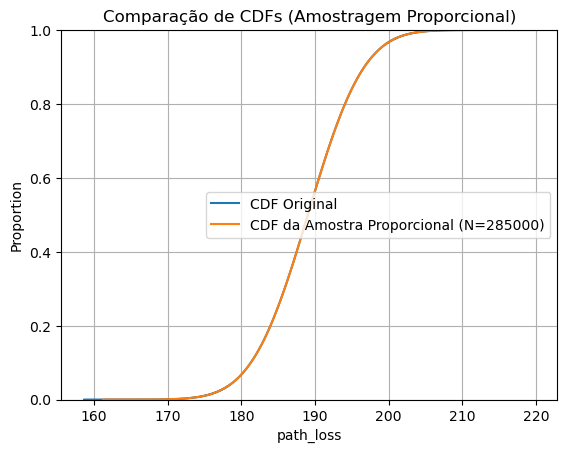

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error



# --- 1. Preparação dos Dados ---
#df = pd.read_csv(r"C:\Users\josef\Documents\UnB\prev_sharc\dados_atualizados_expandido.csv") #windowns
df = pd.read_csv(r"/home/josefelipe/Documentos/UnB/UnB/prev_sharc/dados_atualizados_expandido.csv")#linux
# DataFrame de exemplo
np.random.seed(42)


# Criando a coluna de faixas para a estratificação
bins = [-np.inf,160,164,168, 172,176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220 ,np.inf]
df['faixa_path_loss'] = pd.cut(df['path_loss'], bins=bins, right=False)


# --- 2. Amostragem Estratificada 
N = 285000 # Tamanho da amostra desejada 57*quantidade de drop
tamanho_amostra_proporcional = N / len(df) # Converte o tamanho absoluto para uma fração

# Separando X e a coluna de estratificação y_strat
X = df[['bs_x', 'bs_y', 'path_loss']] # Incluindo path_loss para manter os dados juntos
y_strat = df['faixa_path_loss']

# Usando train_test_split para criar a amostra
# O truque é que só vamos usar a parte "train" do resultado
# O parâmetro 'stratify' garante a amostragem proporcional
df_amostra_proporcional, _ = train_test_split(
    X, # O que queremos amostrar
    train_size=tamanho_amostra_proporcional, # O tamanho da amostra
    stratify=y_strat, # A coluna base para manter as proporções
    random_state=42
)

print(f"Amostra estratificada proporcional de tamanho {len(df_amostra_proporcional)} criada.\n")


# --- 3. Verificação ---
print("--- Proporção na Base Original ---")
print(df['faixa_path_loss'].value_counts(normalize=True).sort_index())
print("\n--- Proporção na Amostra Gerada ---")
# Criamos a faixa de novo só para conferir as proporções
df_amostra_proporcional['faixa_path_loss'] = pd.cut(df_amostra_proporcional['path_loss'], bins=bins, right=False)
print(df_amostra_proporcional['faixa_path_loss'].value_counts(normalize=True).sort_index())

# Plotando para confirmação visual
sns.ecdfplot(data=df, x='path_loss', label='CDF Original')
sns.ecdfplot(data=df_amostra_proporcional, x='path_loss', label=f'CDF da Amostra Proporcional (N={N})')
plt.title('Comparação de CDFs (Amostragem Proporcional)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#pip install pandas numpy scikit-learn matplotlib seaborn tqdm


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Dados de entrada (Condição) e Saída (Dado Real)
conditions = df_amostra_proporcional[['bs_x', 'bs_y']].values
real_data = df_amostra_proporcional[['path_loss']].values

# Normalização dos dados para o intervalo [-1, 1]
condition_scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_conditions = condition_scaler.fit_transform(conditions)
scaled_real_data = data_scaler.fit_transform(real_data)

In [ ]:

# --- Conversão para Tensores PyTorch ---
# Definir o dispositivo (GPU se disponível, senão CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Criar tensores
conditions_tensor = torch.FloatTensor(scaled_conditions).to(device)
data_tensor = torch.FloatTensor(scaled_real_data).to(device)

# Criar um DataLoader para gerenciar os lotes
batch_size = 1024#64
dataset = TensorDataset(data_tensor, conditions_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(batch_size)

Usando dispositivo: cpu
1024


In [ ]:

# --- Parâmetros da cGAN ---
latent_dim = 32      # Dimensão do ruído
conditional_dim = 2  # ue_x, ue_y
data_dim = 1         # path_loss

# --- Construção do Gerador ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, data_dim),
            nn.Tanh() # Normalizamos para [-1, 1], então Tanh é a ativação ideal
        )

    def forward(self, noise, conditions):
        # Concatena o ruído e a condição
        merged_input = torch.cat((noise, conditions), -1)
        return self.model(merged_input)

# --- Construção do Discriminador ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + conditional_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid() # Classifica como Real (1) ou Falso (0)
        )

    def forward(self, data, conditions):
        # Concatena os dados (reais ou falsos) e a condição
        merged_input = torch.cat((data, conditions), -1)
        return self.model(merged_input)

In [10]:

# --- Parâmetros da cGAN ---
latent_dim = 32        # Dimensão do vetor de ruído
conditional_dim = 2    # ue_x, ue_y
data_dim = 1           # path_loss

# --- Gerador Profundo ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, data_dim),
            nn.Tanh()  # Assume path_loss normalizado em [-1, 1]
        )

    def forward(self, noise, conditions):
        merged_input = torch.cat((noise, conditions), dim=-1)
        return self.model(merged_input)

# --- Discriminador Profundo ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + conditional_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Classifica como real (1) ou gerado (0)
        )

    def forward(self, data, conditions):
        merged_input = torch.cat((data, conditions), dim=-1)
        return self.model(merged_input)

# --- Instanciando os modelos ---
generator = Generator()
discriminator = Discriminator()


In [ ]:
# Instanciar os modelos e movê-los para o dispositivo
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Função de perda
adversarial_loss = nn.BCELoss() # Binary Cross Entropy

# Otimizadores
lr = 0.0002#0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

print("--- Arquitetura do Gerador ---")
print(generator)
print("\n--- Arquitetura do Discriminador ---")
print(discriminator)



--- Arquitetura do Gerador ---
Generator(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=128, out_features=1, bias=True)
    (11): Tanh()
  )
)

--- Arquitetura do Discriminador ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=512


Iniciando o treinamento...
[Época 0/80] [D loss: 0.6912] [G loss: 0.7007]
[Época 1/80] [D loss: 0.6929] [G loss: 0.6857]
[Época 2/80] [D loss: 0.6931] [G loss: 0.7090]
[Época 3/80] [D loss: 0.6925] [G loss: 0.6964]
[Época 4/80] [D loss: 0.6947] [G loss: 0.6797]
[Época 5/80] [D loss: 0.6934] [G loss: 0.7053]
[Época 6/80] [D loss: 0.6925] [G loss: 0.6938]
[Época 7/80] [D loss: 0.6928] [G loss: 0.6828]
[Época 8/80] [D loss: 0.6931] [G loss: 0.6791]
[Época 9/80] [D loss: 0.6941] [G loss: 0.6843]
[Época 10/80] [D loss: 0.6925] [G loss: 0.7058]
[Época 11/80] [D loss: 0.6926] [G loss: 0.6870]
[Época 12/80] [D loss: 0.6928] [G loss: 0.6815]
[Época 13/80] [D loss: 0.6933] [G loss: 0.6940]
[Época 14/80] [D loss: 0.6917] [G loss: 0.6921]
[Época 15/80] [D loss: 0.6936] [G loss: 0.6998]
[Época 16/80] [D loss: 0.6935] [G loss: 0.6731]
[Época 17/80] [D loss: 0.6929] [G loss: 0.6873]
[Época 18/80] [D loss: 0.6923] [G loss: 0.6971]
[Época 19/80] [D loss: 0.6930] [G loss: 0.6928]
[Época 20/80] [D loss:

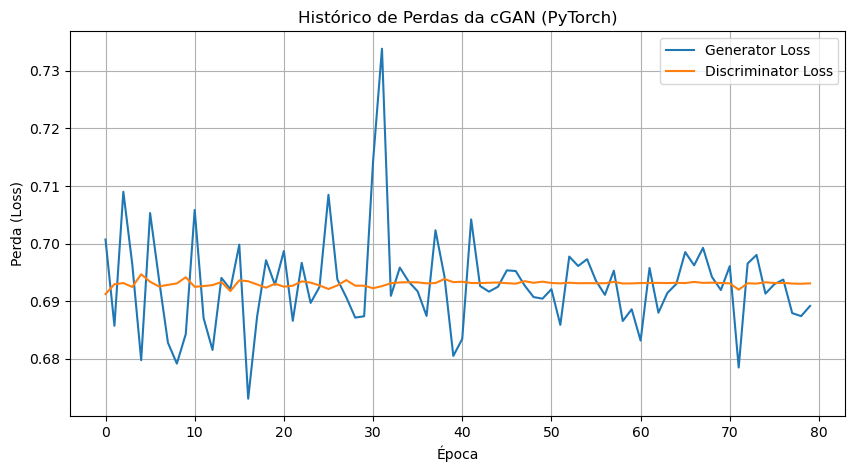

In [ ]:

# --- Treinamento ---
num_epochs = 80
g_losses = []
d_losses = []

print("\nIniciando o treinamento...")
for epoch in range(num_epochs):
    for i, (real_batch_data, real_batch_conditions) in enumerate(dataloader):
        
        # Labels para os dados reais (1) e falsos (0)
        # .view(-1, 1) garante que o shape é [batch_size, 1]
        valid = torch.ones(real_batch_data.size(0), 1, device=device, requires_grad=False)
        fake = torch.zeros(real_batch_data.size(0), 1, device=device, requires_grad=False)

        # ---------------------
        #  Treinar o Discriminador
        # ---------------------
        optimizer_D.zero_grad() # Limpa os gradientes anteriores
        
        # Gerar um lote de dados falsos
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # Calcular a perda para dados reais e falsos
        real_loss = adversarial_loss(discriminator(real_batch_data, real_batch_conditions), valid)
        # Usamos .detach() no dado gerado para não calcular gradientes para o Gerador nesta etapa
        fake_loss = adversarial_loss(discriminator(generated_data.detach(), real_batch_conditions), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        # Backpropagation e atualização dos pesos do Discriminador
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Treinar o Gerador
        # ---------------------
        optimizer_G.zero_grad()
        
        # Gerar um novo lote de dados e tentar enganar o Discriminador
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # O Gerador vence se o Discriminador classificar os dados falsos como reais (label 'valid')
        g_loss = adversarial_loss(discriminator(generated_data, real_batch_conditions), valid)
        
        # Backpropagation e atualização dos pesos do Gerador
        g_loss.backward()
        optimizer_G.step()
    
    # Salvar perdas para plotagem
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1 == 0:
        print(
            f"[Época {epoch}/{num_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
        )
        
print("Treinamento Concluído!")

# Plotar o histórico de perdas
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Histórico de Perdas da cGAN (PyTorch)')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()


Para as coordenadas (x=500, y=500), o path_loss gerado foi: 189.78 dB


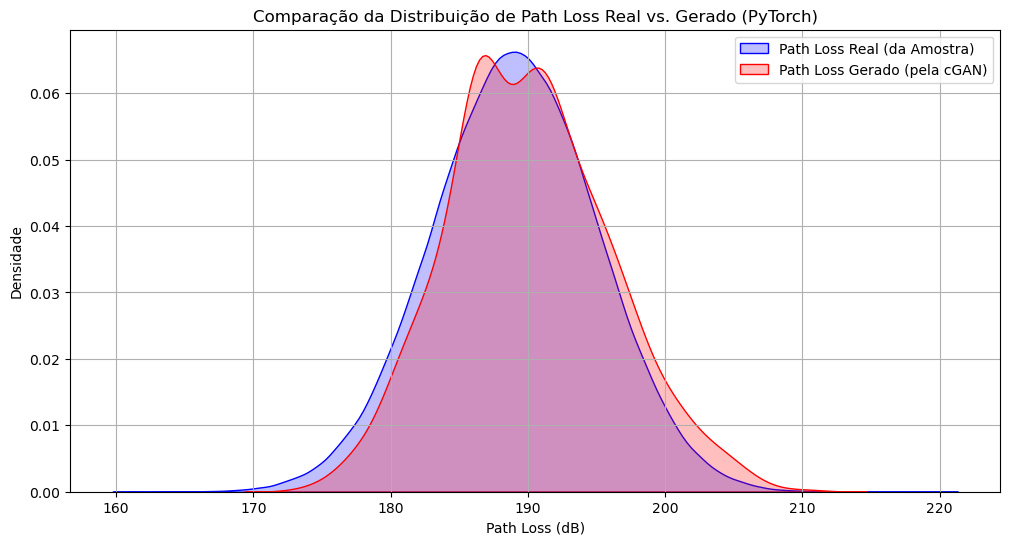

In [13]:
def gerar_pathloss_pytorch(ue_x, ue_y):
    """
    Função para gerar um valor de path_loss com o modelo PyTorch treinado.
    """
    # Coloca o gerador em modo de avaliação
    generator.eval()
    
    # Desativa o cálculo de gradientes para inferência
    with torch.no_grad():
        # 1. Preparar os dados de entrada (condição)
        coords = np.array([[ue_x, ue_y]])
        
        # 2. Escalar os dados
        scaled_coords = condition_scaler.transform(coords)
        
        # 3. Converter para tensor e mover para o dispositivo
        coords_tensor = torch.FloatTensor(scaled_coords).to(device)
        
        # 4. Preparar o ruído
        noise = torch.randn(1, latent_dim, device=device)
        
        # 5. Gerar o path_loss escalado
        scaled_generated_pl = generator(noise, coords_tensor)
        
        # 6. Mover resultado de volta para a CPU e converter para numpy
        generated_pl_numpy = scaled_generated_pl.cpu().numpy()
        
        # 7. Reverter a escala
        original_pl = data_scaler.inverse_transform(generated_pl_numpy)
        
        return original_pl[0][0]

# --- Exemplo de Uso ---
exemplo_x, exemplo_y = 500, 500
path_loss_gerado = gerar_pathloss_pytorch(exemplo_x, exemplo_y)
print(f"\nPara as coordenadas (x={exemplo_x}, y={exemplo_y}), o path_loss gerado foi: {path_loss_gerado:.2f} dB")

# --- Verificação Visual (igual ao código anterior) ---
generator.eval()
with torch.no_grad():
    noise = torch.randn(1000, latent_dim, device=device)
    # Pega 1000 condições aleatórias dos dados de treino
    random_indices = np.random.randint(0, len(conditions_tensor), 1000)
    sample_conditions = conditions_tensor[random_indices]
    
    generated_samples_scaled = generator(noise, sample_conditions)
    generated_samples = data_scaler.inverse_transform(generated_samples_scaled.cpu().numpy())

# Comparar a distribuição dos dados reais e gerados
plt.figure(figsize=(12, 6))
sns.kdeplot(df_amostra_proporcional['path_loss'], label='Path Loss Real (da Amostra)', color='blue', fill=True)
sns.kdeplot(generated_samples.flatten(), label='Path Loss Gerado (pela cGAN)', color='red', fill=True)
plt.title('Comparação da Distribuição de Path Loss Real vs. Gerado (PyTorch)')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()

Gerando 285000 amostras de path_loss com a cGAN...
Amostras geradas com sucesso!


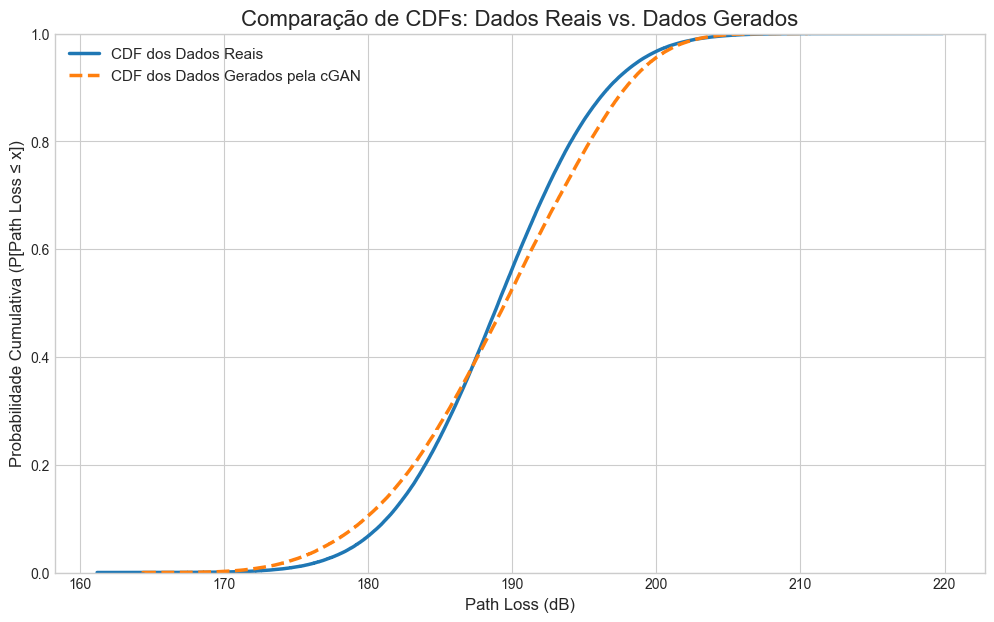

In [ ]:

# --- Passo 1: Gerar uma Amostra Grande de Dados ---

# Define o número de amostras a serem geradas. Um bom número é o tamanho da base de treino.
num_generated_samples = len(df_amostra_proporcional)
print(f"Gerando {num_generated_samples} amostras de path_loss com a cGAN...")

# Coloca o gerador em modo de avaliação
generator.eval()

# Desativa o cálculo de gradientes para acelerar a inferência
with torch.no_grad():
    # Pega condições aleatórias dos dados de treinamento para gerar path_loss correspondente
    random_indices = np.random.randint(0, len(conditions_tensor), num_generated_samples)
    sample_conditions = conditions_tensor[random_indices]
    
    # Gera ruído aleatório
    noise = torch.randn(num_generated_samples, latent_dim, device=device)
    
    # Gera os dados escalados
    generated_samples_scaled = generator(noise, sample_conditions)
    
    # Move os dados para a CPU (se estiver na GPU) e converte para numpy
    generated_samples_numpy = generated_samples_scaled.cpu().numpy()
    
    # Inverte a escala para obter os valores originais de path_loss
    path_loss_gerado = data_scaler.inverse_transform(generated_samples_numpy).flatten()

print("Amostras geradas com sucesso!")


# --- Passo 2: Preparar os Dados para Plotagem ---

# Dados reais da sua amostra original
path_loss_real = df_amostra_proporcional['path_loss'].values


# --- Passo 3: Plotar as CDFs para Comparação ---

plt.style.use('seaborn-v0_8-whitegrid') # Define um estilo bonito para o gráfico
plt.figure(figsize=(12, 7))

# Plotar a CDF dos dados reais
sns.ecdfplot(x=path_loss_real, linewidth=2.5, 
             label='CDF dos Dados Reais')

# Plotar a CDF dos dados gerados pela GAN
sns.ecdfplot(x=path_loss_gerado, linewidth=2.5, linestyle='--',
             label='CDF dos Dados Gerados pela cGAN')

plt.title('Comparação de CDFs: Dados Reais vs. Dados Gerados', fontsize=16)
plt.xlabel('Path Loss (dB)', fontsize=12)
plt.ylabel('Probabilidade Cumulativa (P[Path Loss ≤ x])', fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [ ]:
def gerar_em_batches(df, batch_size=512):
    """
    Gera path loss com a cGAN treinada, processando em batches para evitar estouro de memória.
    """
    df_resultado = df.copy()
    coords = df[['ue_x', 'ue_y']].values
    total = len(coords)
    path_loss_gerado_list = []

    generator.eval()
    with torch.no_grad():
        for i in tqdm(range(0, total, batch_size)):
            # Seleciona o batch
            batch_coords = coords[i:i+batch_size]

            # Escala
            scaled_coords = condition_scaler.transform(batch_coords)
            coords_tensor = torch.FloatTensor(scaled_coords).to(device)

            # Ruído
            noise = torch.randn(len(batch_coords), latent_dim, device=device)

            # Geração
            scaled_generated = generator(noise, coords_tensor)

            # Volta para CPU e desscale
            pl_numpy = scaled_generated.cpu().numpy()
            pl_original = data_scaler.inverse_transform(pl_numpy)

            # Armazena
            path_loss_gerado_list.extend(pl_original.flatten())

    df_resultado['path_loss_gerado'] = path_loss_gerado_list
    return df_resultado


In [12]:
df_com_gerados = gerar_em_batches(df, batch_size=100000)


100%|██████████| 116/116 [00:07<00:00, 16.19it/s]


In [ ]:

# === Métricas ===
y_true = df_com_gerados['path_loss'].values
y_pred = df_com_gerados['path_loss_gerado'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)


print(f"   MAE  = {mae:.4f} dB")
print(f"   MSE  = {mse:.4f} dB²")
print(f"   RMSE = {rmse:.4f} dB")

   MAE  = 6.6488 dB
   MSE  = 68.5274 dB²
   RMSE = 8.2781 dB


C:\Users\josef\AppData\Local\Temp\ipykernel_27512\2722366872.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\josef\AppData\Local\r-miniconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


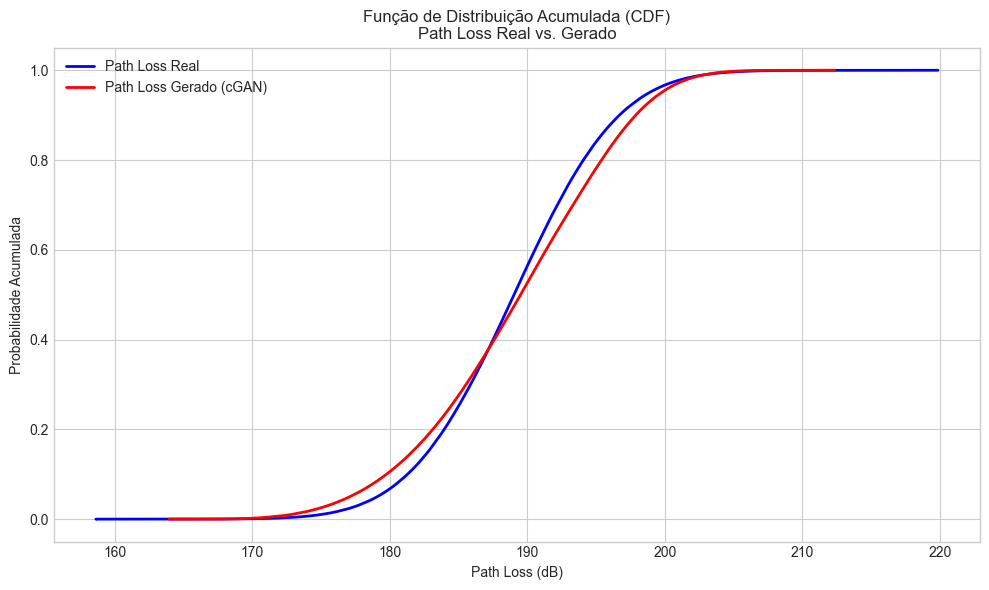

In [ ]:

# Ordenar valores
y_true_sorted = np.sort(y_true)
y_pred_sorted = np.sort(y_pred)

# Construir a CDF manualmente
cdf_true = np.arange(1, len(y_true_sorted)+1) / len(y_true_sorted)
cdf_pred = np.arange(1, len(y_pred_sorted)+1) / len(y_pred_sorted)

plt.figure(figsize=(10, 6))
plt.plot(y_true_sorted, cdf_true, label='Path Loss Real', color='blue', linewidth=2)
plt.plot(y_pred_sorted, cdf_pred, label='Path Loss Gerado (cGAN)', color='red', linewidth=2)

plt.title('Função de Distribuição Acumulada (CDF)\nPath Loss Real vs. Gerado')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 1000 drops

Amostra estratificada proporcional de tamanho 285000 criada.

--- Proporção na Base Original ---
faixa_path_loss
[-inf, 150.0)     0.000000e+00
[150.0, 155.0)    0.000000e+00
[155.0, 156.0)    0.000000e+00
[156.0, 157.0)    0.000000e+00
[157.0, 158.0)    0.000000e+00
[158.0, 159.0)    2.597042e-07
[159.0, 160.0)    2.597042e-07
[160.0, 161.0)    7.791127e-07
[161.0, 162.0)    2.597042e-06
[162.0, 163.0)    4.674676e-06
[163.0, 164.0)    6.752310e-06
[164.0, 165.0)    2.103604e-05
[165.0, 166.0)    3.713771e-05
[166.0, 167.0)    6.986044e-05
[167.0, 168.0)    1.358253e-04
[168.0, 169.0)    2.064649e-04
[169.0, 170.0)    3.812458e-04
[170.0, 172.0)    1.632241e-03
[172.0, 176.0)    1.321869e-02
[176.0, 178.0)    1.835304e-02
[178.0, 180.0)    3.335979e-02
[180.0, 184.0)    1.341133e-01
[184.0, 188.0)    2.295666e-01
[188.0, 192.0)    2.577474e-01
[192.0, 196.0)    1.886175e-01
[196.0, 200.0)    8.935488e-02
[200.0, 204.0)    2.721493e-02
[204.0, 208.0)    5.265503e-03
[208.0, 212.0)    6

/home/josefelipe/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


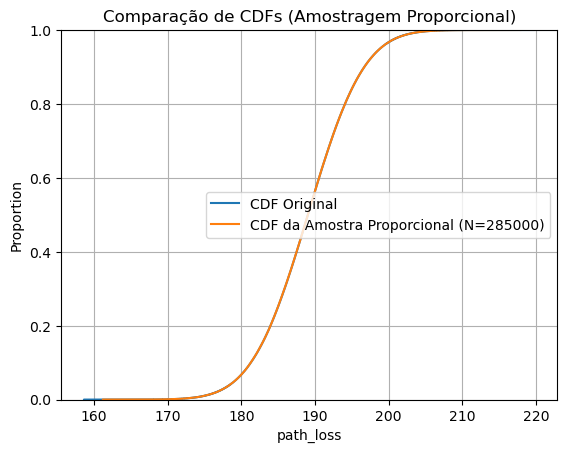

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error



# --- 1. Preparação dos Dados ---
#df = pd.read_csv(r"C:\Users\josef\Documents\UnB\prev_sharc\dados_atualizados_expandido.csv") #windowns
df = pd.read_csv(r"/home/josefelipe/Documentos/UnB/UnB/prev_sharc/dados_atualizados_expandido.csv")#linux
# DataFrame de exemplo
np.random.seed(42)


# Criando a coluna de faixas para a estratificação
bins = [-np.inf,150,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170, 172,176,178, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220 ,np.inf]
df['faixa_path_loss'] = pd.cut(df['path_loss'], bins=bins, right=False)

drop=5000
# --- 2. Amostragem Estratificada 
N = 57*drop # Tamanho da amostra desejada 57*quantidade de drop
tamanho_amostra_proporcional = N / len(df) # Converte o tamanho absoluto para uma fração

# Separando X e a coluna de estratificação y_strat
X = df[['bs_x', 'bs_y', 'path_loss']] # Incluindo path_loss para manter os dados juntos
y_strat = df['faixa_path_loss']

# Usando train_test_split para criar a amostra
# O truque é que só vamos usar a parte "train" do resultado
# O parâmetro 'stratify' garante a amostragem proporcional
df_amostra_proporcional, _ = train_test_split(
    X, # O que queremos amostrar
    train_size=tamanho_amostra_proporcional, # O tamanho da amostra
    stratify=y_strat, # A coluna base para manter as proporções
    random_state=42
)

print(f"Amostra estratificada proporcional de tamanho {len(df_amostra_proporcional)} criada.\n")


# --- 3. Verificação ---
print("--- Proporção na Base Original ---")
print(df['faixa_path_loss'].value_counts(normalize=True).sort_index())
print("\n--- Proporção na Amostra Gerada ---")
# Criamos a faixa de novo só para conferir as proporções
df_amostra_proporcional['faixa_path_loss'] = pd.cut(df_amostra_proporcional['path_loss'], bins=bins, right=False)
print(df_amostra_proporcional['faixa_path_loss'].value_counts(normalize=True).sort_index())

# Plotando para confirmação visual
sns.ecdfplot(data=df, x='path_loss', label='CDF Original')
sns.ecdfplot(data=df_amostra_proporcional, x='path_loss', label=f'CDF da Amostra Proporcional (N={N})')
plt.title('Comparação de CDFs (Amostragem Proporcional)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Dados de entrada (Condição) e Saída (Dado Real)
conditions = df_amostra_proporcional[['bs_x', 'bs_y']].values
real_data = df_amostra_proporcional[['path_loss']].values

# Normalização dos dados para o intervalo [-1, 1]
condition_scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_conditions = condition_scaler.fit_transform(conditions)
scaled_real_data = data_scaler.fit_transform(real_data)

In [9]:
# Normalização para um intervalo que EVITA as fronteiras -1 e 1
condition_scaler = MinMaxScaler(feature_range=(-1, 1)) # Condições podem ficar em [-1, 1]
data_scaler = MinMaxScaler(feature_range=(-0.9, 0.9)) # <-- CORREÇÃO APLICADA

scaled_conditions = condition_scaler.fit_transform(conditions)
scaled_real_data = data_scaler.fit_transform(real_data)
# --- Conversão para Tensores PyTorch ---
# Definir o dispositivo (GPU se disponível, senão CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Criar tensores
conditions_tensor = torch.FloatTensor(scaled_conditions).to(device)
data_tensor = torch.FloatTensor(scaled_real_data).to(device)

# Criar um DataLoader para gerenciar os lotes
batch_size = 1024#64
dataset = TensorDataset(data_tensor, conditions_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(batch_size)

Usando dispositivo: cpu
1024


In [10]:

# --- Parâmetros da cGAN ---
latent_dim = 32      # Dimensão do ruído
conditional_dim = 2  # ue_x, ue_y
data_dim = 1         # path_loss

# --- Construção do Gerador ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, data_dim),
            nn.Tanh() # Normalizamos para [-1, 1], então Tanh é a ativação ideal
        )

    def forward(self, noise, conditions):
        # Concatena o ruído e a condição
        merged_input = torch.cat((noise, conditions), -1)
        return self.model(merged_input)

# --- Construção do Discriminador ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + conditional_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid() # Classifica como Real (1) ou Falso (0)
        )

    def forward(self, data, conditions):
        # Concatena os dados (reais ou falsos) e a condição
        merged_input = torch.cat((data, conditions), -1)
        return self.model(merged_input)

--- Arquitetura do Gerador ---
Generator(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Tanh()
  )
)

--- Arquitetura do Discriminador ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Iniciando o treinamento...
[Época 0/180] [D loss: 0.6923] [G loss: 0.6922]
[Época 5/180] [D loss: 0.6968] [G loss: 0.6910]
[Época 10/180] [D loss: 0.6949] [

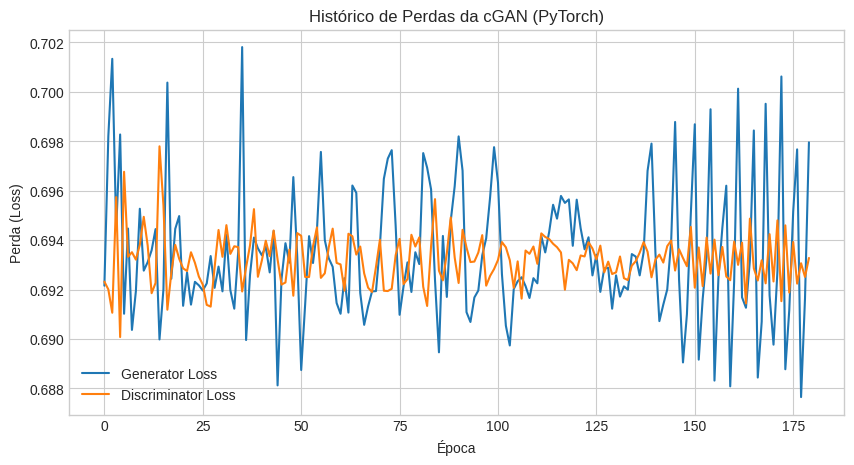

In [15]:
# Instanciar os modelos e movê-los para o dispositivo
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Função de perda
adversarial_loss = nn.BCELoss() # Binary Cross Entropy

# Otimizadores
lr = 0.00001#0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

print("--- Arquitetura do Gerador ---")
print(generator)
print("\n--- Arquitetura do Discriminador ---")
print(discriminator)


# --- Treinamento ---
num_epochs = 180
g_losses = []
d_losses = []

print("\nIniciando o treinamento...")
for epoch in range(num_epochs):
    for i, (real_batch_data, real_batch_conditions) in enumerate(dataloader):
        
        # Labels para os dados reais (1) e falsos (0)
        # .view(-1, 1) garante que o shape é [batch_size, 1]
        valid = torch.ones(real_batch_data.size(0), 1, device=device, requires_grad=False)
        fake = torch.zeros(real_batch_data.size(0), 1, device=device, requires_grad=False)

        # ---------------------
        #  Treinar o Discriminador
        # ---------------------
        optimizer_D.zero_grad() # Limpa os gradientes anteriores
        
        # Gerar um lote de dados falsos
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # Calcular a perda para dados reais e falsos
        real_loss = adversarial_loss(discriminator(real_batch_data, real_batch_conditions), valid)
        # Usamos .detach() no dado gerado para não calcular gradientes para o Gerador nesta etapa
        fake_loss = adversarial_loss(discriminator(generated_data.detach(), real_batch_conditions), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        # Backpropagation e atualização dos pesos do Discriminador
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Treinar o Gerador
        # ---------------------
        optimizer_G.zero_grad()
        
        # Gerar um novo lote de dados e tentar enganar o Discriminador
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # O Gerador vence se o Discriminador classificar os dados falsos como reais (label 'valid')
        g_loss = adversarial_loss(discriminator(generated_data, real_batch_conditions), valid)
        
        # Backpropagation e atualização dos pesos do Gerador
        g_loss.backward()
        optimizer_G.step()
    
    # Salvar perdas para plotagem
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 5 == 0:
        print(
            f"[Época {epoch}/{num_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
        )
        
print("Treinamento Concluído!")

# Plotar o histórico de perdas
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Histórico de Perdas da cGAN (PyTorch)')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()


Para as coordenadas (x=500, y=500), o path_loss gerado foi: 195.87 dB


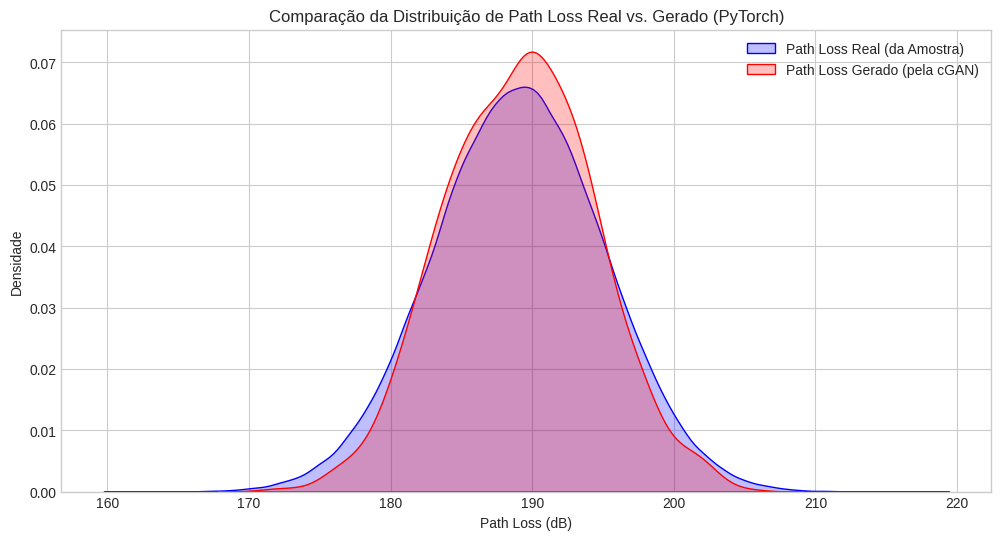

In [16]:
def gerar_pathloss_pytorch(ue_x, ue_y):
    """
    Função para gerar um valor de path_loss com o modelo PyTorch treinado.
    """
    # Coloca o gerador em modo de avaliação
    generator.eval()
    
    # Desativa o cálculo de gradientes para inferência
    with torch.no_grad():
        # 1. Preparar os dados de entrada (condição)
        coords = np.array([[ue_x, ue_y]])
        
        # 2. Escalar os dados
        scaled_coords = condition_scaler.transform(coords)
        
        # 3. Converter para tensor e mover para o dispositivo
        coords_tensor = torch.FloatTensor(scaled_coords).to(device)
        
        # 4. Preparar o ruído
        noise = torch.randn(1, latent_dim, device=device)
        
        # 5. Gerar o path_loss escalado
        scaled_generated_pl = generator(noise, coords_tensor)
        
        # 6. Mover resultado de volta para a CPU e converter para numpy
        generated_pl_numpy = scaled_generated_pl.cpu().numpy()
        
        # 7. Reverter a escala
        original_pl = data_scaler.inverse_transform(generated_pl_numpy)
        
        return original_pl[0][0]

# --- Exemplo de Uso ---
exemplo_x, exemplo_y = 500, 500
path_loss_gerado = gerar_pathloss_pytorch(exemplo_x, exemplo_y)
print(f"\nPara as coordenadas (x={exemplo_x}, y={exemplo_y}), o path_loss gerado foi: {path_loss_gerado:.2f} dB")

# --- Verificação Visual (igual ao código anterior) ---
generator.eval()
with torch.no_grad():
    noise = torch.randn(1000, latent_dim, device=device)
    # Pega 1000 condições aleatórias dos dados de treino
    random_indices = np.random.randint(0, len(conditions_tensor), 1000)
    sample_conditions = conditions_tensor[random_indices]
    
    generated_samples_scaled = generator(noise, sample_conditions)
    generated_samples = data_scaler.inverse_transform(generated_samples_scaled.cpu().numpy())

# Comparar a distribuição dos dados reais e gerados
plt.figure(figsize=(12, 6))
sns.kdeplot(df_amostra_proporcional['path_loss'], label='Path Loss Real (da Amostra)', color='blue', fill=True)
sns.kdeplot(generated_samples.flatten(), label='Path Loss Gerado (pela cGAN)', color='red', fill=True)
plt.title('Comparação da Distribuição de Path Loss Real vs. Gerado (PyTorch)')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()

Gerando 285000 amostras de path_loss com a cGAN...
Amostras geradas com sucesso!


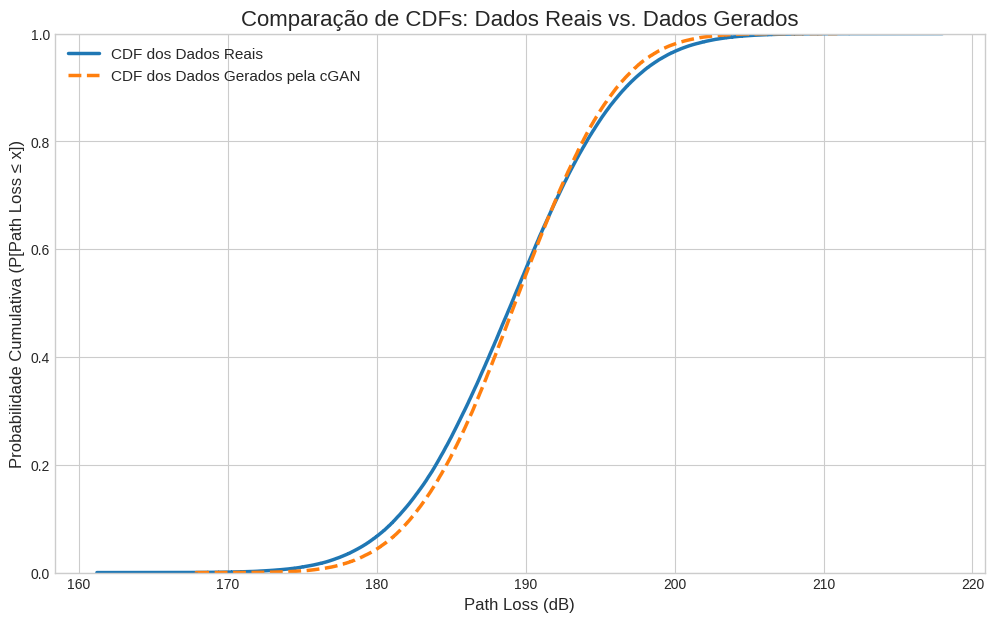

In [17]:

# --- Passo 1: Gerar uma Amostra Grande de Dados ---

# Define o número de amostras a serem geradas. Um bom número é o tamanho da base de treino.
num_generated_samples = len(df_amostra_proporcional)
print(f"Gerando {num_generated_samples} amostras de path_loss com a cGAN...")

# Coloca o gerador em modo de avaliação
generator.eval()

# Desativa o cálculo de gradientes para acelerar a inferência
with torch.no_grad():
    # Pega condições aleatórias dos dados de treinamento para gerar path_loss correspondente
    random_indices = np.random.randint(0, len(conditions_tensor), num_generated_samples)
    sample_conditions = conditions_tensor[random_indices]
    
    # Gera ruído aleatório
    noise = torch.randn(num_generated_samples, latent_dim, device=device)
    
    # Gera os dados escalados
    generated_samples_scaled = generator(noise, sample_conditions)
    
    # Move os dados para a CPU (se estiver na GPU) e converte para numpy
    generated_samples_numpy = generated_samples_scaled.cpu().numpy()
    
    # Inverte a escala para obter os valores originais de path_loss
    path_loss_gerado = data_scaler.inverse_transform(generated_samples_numpy).flatten()

print("Amostras geradas com sucesso!")


# --- Passo 2: Preparar os Dados para Plotagem ---

# Dados reais da sua amostra original
path_loss_real = df_amostra_proporcional['path_loss'].values


# --- Passo 3: Plotar as CDFs para Comparação ---

plt.style.use('seaborn-v0_8-whitegrid') # Define um estilo bonito para o gráfico
plt.figure(figsize=(12, 7))

# Plotar a CDF dos dados reais
sns.ecdfplot(x=path_loss_real, linewidth=2.5, 
             label='CDF dos Dados Reais')

# Plotar a CDF dos dados gerados pela GAN
sns.ecdfplot(x=path_loss_gerado, linewidth=2.5, linestyle='--',
             label='CDF dos Dados Gerados pela cGAN')

plt.title('Comparação de CDFs: Dados Reais vs. Dados Gerados', fontsize=16)
plt.xlabel('Path Loss (dB)', fontsize=12)
plt.ylabel('Probabilidade Cumulativa (P[Path Loss ≤ x])', fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [18]:
def gerar_em_batches(df, batch_size=512):
    """
    Gera path loss com a cGAN treinada, processando em batches para evitar estouro de memória.
    """
    df_resultado = df.copy()
    coords = df[['ue_x', 'ue_y']].values
    total = len(coords)
    path_loss_gerado_list = []

    generator.eval()
    with torch.no_grad():
        for i in tqdm(range(0, total, batch_size)):
            # Seleciona o batch
            batch_coords = coords[i:i+batch_size]

            # Escala
            scaled_coords = condition_scaler.transform(batch_coords)
            coords_tensor = torch.FloatTensor(scaled_coords).to(device)

            # Ruído
            noise = torch.randn(len(batch_coords), latent_dim, device=device)

            # Geração
            scaled_generated = generator(noise, coords_tensor)

            # Volta para CPU e desscale
            pl_numpy = scaled_generated.cpu().numpy()
            pl_original = data_scaler.inverse_transform(pl_numpy)

            # Armazena
            path_loss_gerado_list.extend(pl_original.flatten())

    df_resultado['path_loss_gerado'] = path_loss_gerado_list
    return df_resultado


100%|██████████| 116/116 [00:13<00:00,  8.57it/s]


   MAE  = 6.0099 dB
   MSE  = 56.6015 dB²
   RMSE = 7.5234 dB


/tmp/ipykernel_10942/2916511978.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/josefelipe/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


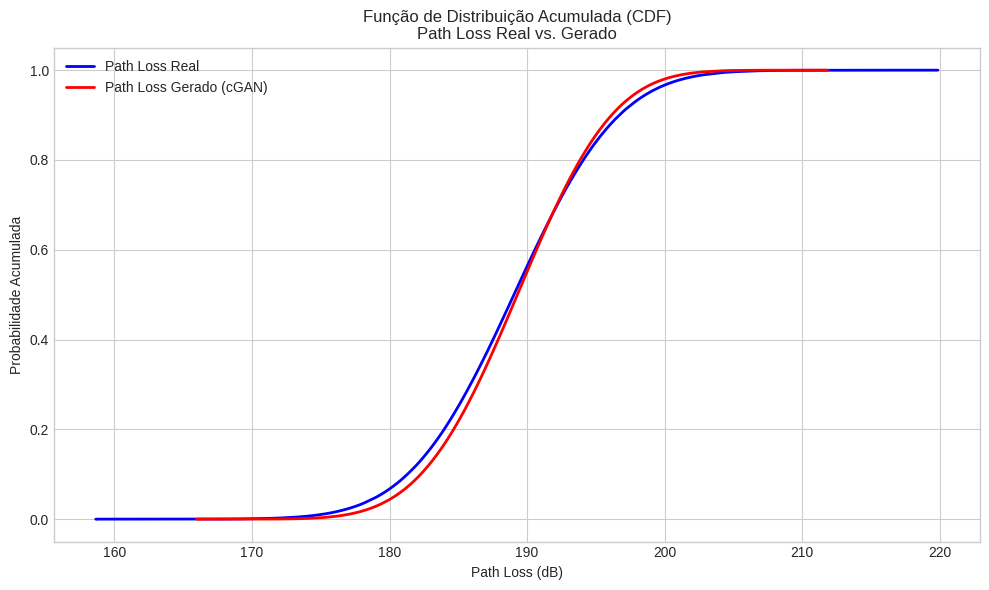

In [19]:
df_com_gerados = gerar_em_batches(df, batch_size=100000)

# === Métricas ===
y_true = df_com_gerados['path_loss'].values
y_pred = df_com_gerados['path_loss_gerado'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)


print(f"   MAE  = {mae:.4f} dB")
print(f"   MSE  = {mse:.4f} dB²")
print(f"   RMSE = {rmse:.4f} dB")
# Ordenar valores
y_true_sorted = np.sort(y_true)
y_pred_sorted = np.sort(y_pred)

# Construir a CDF manualmente
cdf_true = np.arange(1, len(y_true_sorted)+1) / len(y_true_sorted)
cdf_pred = np.arange(1, len(y_pred_sorted)+1) / len(y_pred_sorted)

plt.figure(figsize=(10, 6))
plt.plot(y_true_sorted, cdf_true, label='Path Loss Real', color='blue', linewidth=2)
plt.plot(y_pred_sorted, cdf_pred, label='Path Loss Gerado (cGAN)', color='red', linewidth=2)

plt.title('Função de Distribuição Acumulada (CDF)\nPath Loss Real vs. Gerado')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# salvar modelo

In [20]:

################################
import os
import joblib

# --- Bloco de Código para Salvar o Modelo ---

# 1. Definir o nome da pasta onde o modelo será salvo
output_dir = "modelo_5000_drops_lr_pequeno"
os.makedirs(output_dir, exist_ok=True) # Cria a pasta se ela não existir

# 2. Definir os caminhos para os arquivos
path_generator = os.path.join(output_dir, "generator.pth")
path_discriminator = os.path.join(output_dir, "discriminator.pth")
path_condition_scaler = os.path.join(output_dir, "condition_scaler.pkl")
path_data_scaler = os.path.join(output_dir, "data_scaler.pkl")

# 3. Salvar os state_dict (pesos) dos modelos
# É a maneira recomendada pelo PyTorch, pois é mais flexível
torch.save(generator.state_dict(), path_generator)
torch.save(discriminator.state_dict(), path_discriminator)

# 4. Salvar os scalers usando joblib (bom para objetos do scikit-learn)
joblib.dump(condition_scaler, path_condition_scaler)
joblib.dump(data_scaler, path_data_scaler)

print("\n" + "="*50)
print(f"Modelo e scalers salvos com sucesso na pasta: '{output_dir}'")
print(f"  - Gerador: {path_generator}")
print(f"  - Discriminador: {path_discriminator}")
print(f"  - Scaler de Condição: {path_condition_scaler}")
print(f"  - Scaler de Dados: {path_data_scaler}")
print("="*50)


Modelo e scalers salvos com sucesso na pasta: 'modelo_5000_drops_lr_pequeno'
  - Gerador: modelo_5000_drops_lr_pequeno/generator.pth
  - Discriminador: modelo_5000_drops_lr_pequeno/discriminator.pth
  - Scaler de Condição: modelo_5000_drops_lr_pequeno/condition_scaler.pkl
  - Scaler de Dados: modelo_5000_drops_lr_pequeno/data_scaler.pkl


Amostra estratificada proporcional de tamanho 285000 criada.

--- Proporção na Base Original ---
faixa_path_loss
[-inf, 150.0)     0.000000e+00
[150.0, 155.0)    0.000000e+00
[155.0, 156.0)    0.000000e+00
[156.0, 157.0)    0.000000e+00
[157.0, 158.0)    0.000000e+00
[158.0, 159.0)    2.597042e-07
[159.0, 160.0)    2.597042e-07
[160.0, 161.0)    7.791127e-07
[161.0, 162.0)    2.597042e-06
[162.0, 163.0)    4.674676e-06
[163.0, 164.0)    6.752310e-06
[164.0, 165.0)    2.103604e-05
[165.0, 166.0)    3.713771e-05
[166.0, 167.0)    6.986044e-05
[167.0, 168.0)    1.358253e-04
[168.0, 169.0)    2.064649e-04
[169.0, 170.0)    3.812458e-04
[170.0, 172.0)    1.632241e-03
[172.0, 176.0)    1.321869e-02
[176.0, 178.0)    1.835304e-02
[178.0, 180.0)    3.335979e-02
[180.0, 184.0)    1.341133e-01
[184.0, 188.0)    2.295666e-01
[188.0, 192.0)    2.577474e-01
[192.0, 196.0)    1.886175e-01
[196.0, 200.0)    8.935488e-02
[200.0, 204.0)    2.721493e-02
[204.0, 208.0)    5.265503e-03
[208.0, 212.0)    6

/home/josefelipe/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


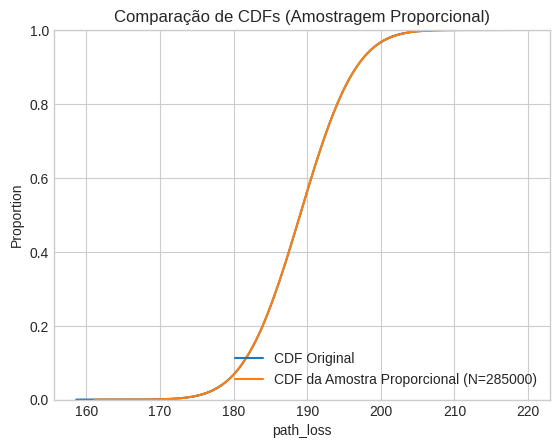

Usando dispositivo: cpu
128
--- Arquitetura do Gerador ---
Generator(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Linear(in_features=512, out_features=256, bias=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=256, out_features=1, bias=True)
    (13): Tanh()
  )
)

--- Arquitetura do Discriminador ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=512, bia

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error



# --- 1. Preparação dos Dados ---
#df = pd.read_csv(r"C:\Users\josef\Documents\UnB\prev_sharc\dados_atualizados_expandido.csv") #windowns
df = pd.read_csv(r"/home/josefelipe/Documentos/UnB/UnB/prev_sharc/dados_atualizados_expandido.csv")#linux
# DataFrame de exemplo
np.random.seed(42)

# --- 1. Preparação dos Dados 
#df = pd.read_csv(r"C:\Users\josef\Documents\UnB\prev_sharc\dados_atualizados_expandido.csv")
#foi carregado

np.random.seed(42)


# Criando a coluna de faixas para a estratificação
# Criando a coluna de faixas para a estratificação

bins = [-np.inf,150,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170, 172,176,178, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220 ,np.inf]
df['faixa_path_loss'] = pd.cut(df['path_loss'], bins=bins, right=False)

drop=5000
# --- 2. Amostragem Estratificada 
N = 57*drop # Tamanho da amostra desejada 57*quantidade de drop
tamanho_amostra_proporcional = N / len(df) # Converte o tamanho absoluto para uma fração

# Separando X e a coluna de estratificação y_strat
X = df[['bs_x', 'bs_y', 'path_loss']] # Incluindo path_loss para manter os dados juntos
y_strat = df['faixa_path_loss']

# Usando train_test_split para criar a amostra
# O truque é que só vamos usar a parte "train" do resultado
# O parâmetro 'stratify' garante a amostragem proporcional
df_amostra_proporcional, _ = train_test_split(
    X, # O que queremos amostrar
    train_size=tamanho_amostra_proporcional, # O tamanho da amostra
    stratify=y_strat, # A coluna base para manter as proporções
    random_state=42
)

print(f"Amostra estratificada proporcional de tamanho {len(df_amostra_proporcional)} criada.\n")


# --- 3. Verificação ---
print("--- Proporção na Base Original ---")
print(df['faixa_path_loss'].value_counts(normalize=True).sort_index())
print("\n--- Proporção na Amostra Gerada ---")
# Criamos a faixa de novo só para conferir as proporções
df_amostra_proporcional['faixa_path_loss'] = pd.cut(df_amostra_proporcional['path_loss'], bins=bins, right=False)
print(df_amostra_proporcional['faixa_path_loss'].value_counts(normalize=True).sort_index())

# Plotando para confirmação visual
sns.ecdfplot(data=df, x='path_loss', label='CDF Original')
sns.ecdfplot(data=df_amostra_proporcional, x='path_loss', label=f'CDF da Amostra Proporcional (N={N})')
plt.title('Comparação de CDFs (Amostragem Proporcional)')
plt.legend()
plt.grid(True)
plt.show()



# Dados de entrada (Condição) e Saída (Dado Real)
conditions = df_amostra_proporcional[['bs_x', 'bs_y']].values
real_data = df_amostra_proporcional[['path_loss']].values

# Normalização dos dados para o intervalo [-1, 1]
condition_scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_conditions = condition_scaler.fit_transform(conditions)
scaled_real_data = data_scaler.fit_transform(real_data)


# --- Conversão para Tensores PyTorch ---
# Definir o dispositivo (GPU se disponível, senão CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Criar tensores
conditions_tensor = torch.FloatTensor(scaled_conditions).to(device)
data_tensor = torch.FloatTensor(scaled_real_data).to(device)

# Criar um DataLoader para gerenciar os lotes
batch_size = 128#64
dataset = TensorDataset(data_tensor, conditions_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(batch_size)




# --- Parâmetros da cGAN ---
latent_dim = 32      # Dimensão do ruído
conditional_dim = 2  # ue_x, ue_y
data_dim = 1         # path_loss

#gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, data_dim),
            nn.Tanh()  # Mantenha se os dados estiverem normalizados
        )

    def forward(self, noise, conditions):
        merged_input = torch.cat((noise, conditions), dim=-1)
        return self.model(merged_input)

#verificador

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + conditional_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, data, conditions):
        merged_input = torch.cat((data, conditions), dim=-1)
        return self.model(merged_input)




In [22]:

# --- Parâmetros da cGAN ---
latent_dim = 32      # Dimensão do ruído
conditional_dim = 2  # ue_x, ue_y
data_dim = 1         # path_loss

# --- Construção do Gerador ---
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, data_dim),
            nn.Tanh() # Normalizamos para [-1, 1], então Tanh é a ativação ideal
        )

    def forward(self, noise, conditions):
        # Concatena o ruído e a condição
        merged_input = torch.cat((noise, conditions), -1)
        return self.model(merged_input)

# --- Construção do Discriminador ---
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim + conditional_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid() # Classifica como Real (1) ou Falso (0)
        )

    def forward(self, data, conditions):
        # Concatena os dados (reais ou falsos) e a condição
        merged_input = torch.cat((data, conditions), -1)
        return self.model(merged_input)

--- Arquitetura do Gerador ---
Generator(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Tanh()
  )
)

--- Arquitetura do Discriminador ---
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Iniciando o treinamento...
[Época 0/550] [D loss: 0.6949] [G loss: 0.6926]
[Época 1/550] [D loss: 0.6891] [G loss: 0.7011]
[Época 2/550] [D loss: 0.6987] [G

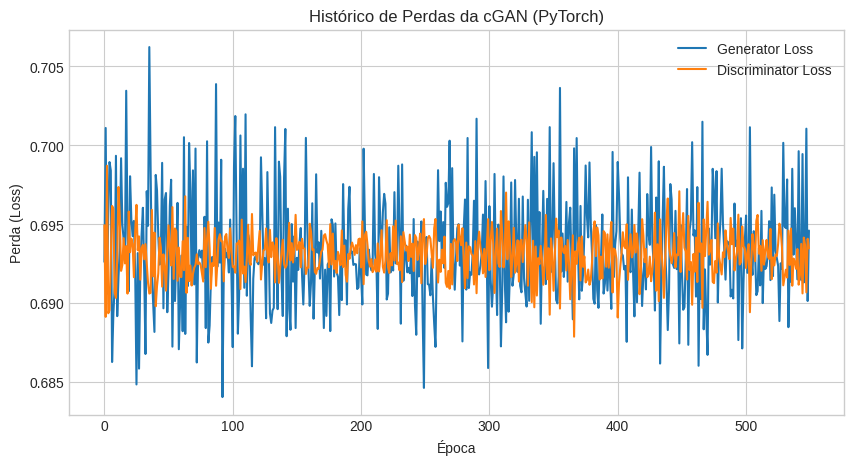


Para as coordenadas (x=500, y=500), o path_loss gerado foi: 189.82 dB


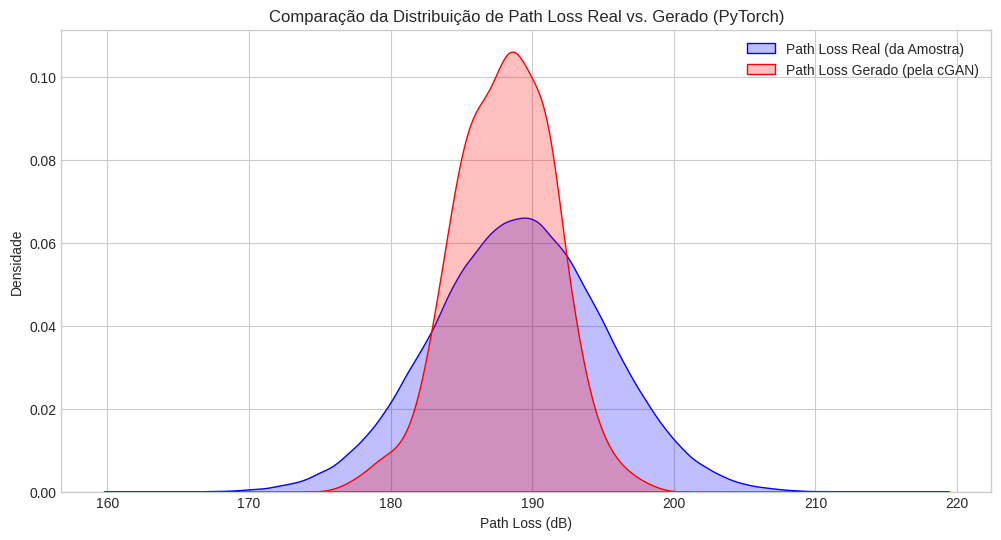

Gerando 285000 amostras de path_loss com a cGAN...
Amostras geradas com sucesso!


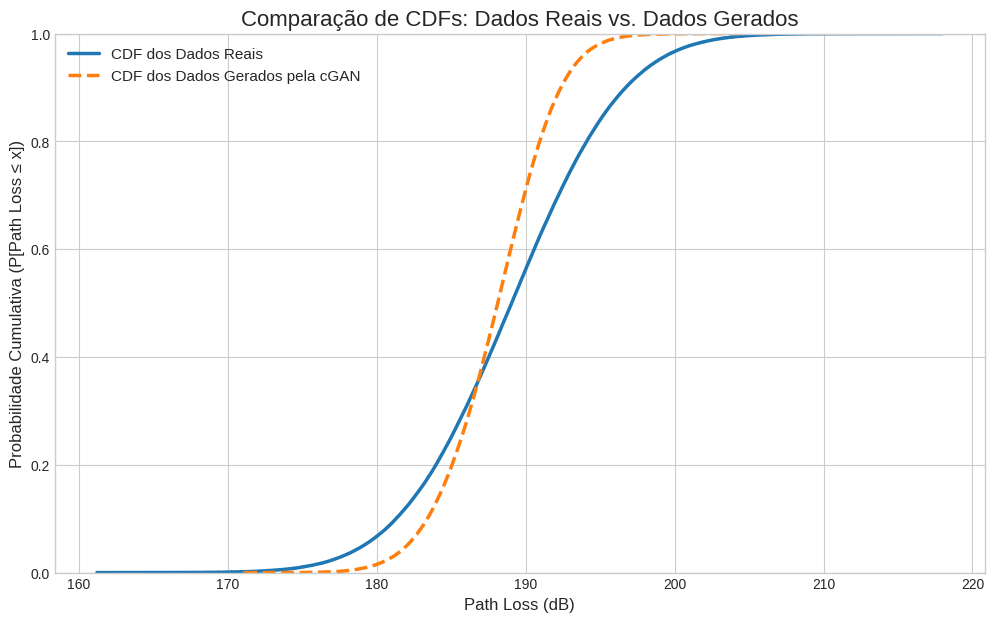

In [25]:
# Instanciar os modelos e movê-los para o dispositivo
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Função de perda
adversarial_loss = nn.BCELoss() # Binary Cross Entropy

# Otimizadores
lr = 0.00002#0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

print("--- Arquitetura do Gerador ---")
print(generator)
print("\n--- Arquitetura do Discriminador ---")
print(discriminator)


# --- Treinamento ---
num_epochs = 550
g_losses = []
d_losses = []

print("\nIniciando o treinamento...")
for epoch in range(num_epochs):
    for i, (real_batch_data, real_batch_conditions) in enumerate(dataloader):
        
        # Labels para os dados reais (1) e falsos (0)
        # .view(-1, 1) garante que o shape é [batch_size, 1]
        valid = torch.ones(real_batch_data.size(0), 1, device=device, requires_grad=False)
        fake = torch.zeros(real_batch_data.size(0), 1, device=device, requires_grad=False)

        # ---------------------
        #  Treinar o Discriminador
        # ---------------------
        optimizer_D.zero_grad() # Limpa os gradientes anteriores
        
        # Gerar um lote de dados falsos
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # Calcular a perda para dados reais e falsos
        real_loss = adversarial_loss(discriminator(real_batch_data, real_batch_conditions), valid)
        # Usamos .detach() no dado gerado para não calcular gradientes para o Gerador nesta etapa
        fake_loss = adversarial_loss(discriminator(generated_data.detach(), real_batch_conditions), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        # Backpropagation e atualização dos pesos do Discriminador
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Treinar o Gerador
        # ---------------------
        optimizer_G.zero_grad()
        
        # Gerar um novo lote de dados e tentar enganar o Discriminador
        noise = torch.randn(real_batch_data.size(0), latent_dim, device=device)
        generated_data = generator(noise, real_batch_conditions)
        
        # O Gerador vence se o Discriminador classificar os dados falsos como reais (label 'valid')
        g_loss = adversarial_loss(discriminator(generated_data, real_batch_conditions), valid)
        
        # Backpropagation e atualização dos pesos do Gerador
        g_loss.backward()
        optimizer_G.step()
    
    # Salvar perdas para plotagem
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1 == 0:
        print(
            f"[Época {epoch}/{num_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
        )
        
print("Treinamento Concluído!")

# Plotar o histórico de perdas
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Histórico de Perdas da cGAN (PyTorch)')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()




def gerar_pathloss_pytorch(ue_x, ue_y):
    """
    Função para gerar um valor de path_loss com o modelo PyTorch treinado.
    """
    # Coloca o gerador em modo de avaliação
    generator.eval()
    
    # Desativa o cálculo de gradientes para inferência
    with torch.no_grad():
        # 1. Preparar os dados de entrada (condição)
        coords = np.array([[ue_x, ue_y]])
        
        # 2. Escalar os dados
        scaled_coords = condition_scaler.transform(coords)
        
        # 3. Converter para tensor e mover para o dispositivo
        coords_tensor = torch.FloatTensor(scaled_coords).to(device)
        
        # 4. Preparar o ruído
        noise = torch.randn(1, latent_dim, device=device)
        
        # 5. Gerar o path_loss escalado
        scaled_generated_pl = generator(noise, coords_tensor)
        
        # 6. Mover resultado de volta para a CPU e converter para numpy
        generated_pl_numpy = scaled_generated_pl.cpu().numpy()
        
        # 7. Reverter a escala
        original_pl = data_scaler.inverse_transform(generated_pl_numpy)
        
        return original_pl[0][0]

# --- Exemplo de Uso ---
exemplo_x, exemplo_y = 500, 500
path_loss_gerado = gerar_pathloss_pytorch(exemplo_x, exemplo_y)
print(f"\nPara as coordenadas (x={exemplo_x}, y={exemplo_y}), o path_loss gerado foi: {path_loss_gerado:.2f} dB")

# --- Verificação Visual (igual ao código anterior) ---
generator.eval()
with torch.no_grad():
    noise = torch.randn(1000, latent_dim, device=device)
    # Pega 1000 condições aleatórias dos dados de treino
    random_indices = np.random.randint(0, len(conditions_tensor), 1000)
    sample_conditions = conditions_tensor[random_indices]
    
    generated_samples_scaled = generator(noise, sample_conditions)
    generated_samples = data_scaler.inverse_transform(generated_samples_scaled.cpu().numpy())

# Comparar a distribuição dos dados reais e gerados
plt.figure(figsize=(12, 6))
sns.kdeplot(df_amostra_proporcional['path_loss'], label='Path Loss Real (da Amostra)', color='blue', fill=True)
sns.kdeplot(generated_samples.flatten(), label='Path Loss Gerado (pela cGAN)', color='red', fill=True)
plt.title('Comparação da Distribuição de Path Loss Real vs. Gerado (PyTorch)')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()




import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# --- Passo 1: Gerar uma Amostra Grande de Dados ---

# Define o número de amostras a serem geradas. Um bom número é o tamanho da base de treino.
num_generated_samples = len(df_amostra_proporcional)
print(f"Gerando {num_generated_samples} amostras de path_loss com a cGAN...")

# Coloca o gerador em modo de avaliação
generator.eval()

# Desativa o cálculo de gradientes para acelerar a inferência
with torch.no_grad():
    # Pega condições aleatórias dos dados de treinamento para gerar path_loss correspondente
    random_indices = np.random.randint(0, len(conditions_tensor), num_generated_samples)
    sample_conditions = conditions_tensor[random_indices]
    
    # Gera ruído aleatório
    noise = torch.randn(num_generated_samples, latent_dim, device=device)
    
    # Gera os dados escalados
    generated_samples_scaled = generator(noise, sample_conditions)
    
    # Move os dados para a CPU (se estiver na GPU) e converte para numpy
    generated_samples_numpy = generated_samples_scaled.cpu().numpy()
    
    # Inverte a escala para obter os valores originais de path_loss
    path_loss_gerado = data_scaler.inverse_transform(generated_samples_numpy).flatten()

print("Amostras geradas com sucesso!")


# --- Passo 2: Preparar os Dados para Plotagem ---

# Dados reais da sua amostra original
path_loss_real = df_amostra_proporcional['path_loss'].values


# --- Passo 3: Plotar as CDFs para Comparação ---

plt.style.use('seaborn-v0_8-whitegrid') # Define um estilo bonito para o gráfico
plt.figure(figsize=(12, 7))

# Plotar a CDF dos dados reais
sns.ecdfplot(x=path_loss_real, linewidth=2.5, 
             label='CDF dos Dados Reais')

# Plotar a CDF dos dados gerados pela GAN
sns.ecdfplot(x=path_loss_gerado, linewidth=2.5, linestyle='--',
             label='CDF dos Dados Gerados pela cGAN')

plt.title('Comparação de CDFs: Dados Reais vs. Dados Gerados', fontsize=16)
plt.xlabel('Path Loss (dB)', fontsize=12)
plt.ylabel('Probabilidade Cumulativa (P[Path Loss ≤ x])', fontsize=12)
plt.legend(fontsize=11)
plt.show()